In [24]:
# load libraries
import cv2
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
import itertools
import time
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
%matplotlib inline

In [25]:
nb_train_samples = 22046 #  modify for your dataset
nb_valid_samples = 2756 #  modify for your dataset
nb_test_samples = 2756 # modify for your dataset
num_classes = 2 # binary classification 
img_rows_orig = 100 # modify these values for your requirements 
img_cols_orig = 100

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
def load_resized_training_data(img_rows, img_cols):

    X_train = np.load("x_train.npy")
    Y_train = np.load("y_train.npy")
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
    
    return X_train, Y_train
    
def load_resized_validation_data(img_rows, img_cols):

    X_valid = np.load("x_val.npy")
    Y_valid = np.load("y_val.npy")
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    return X_valid, Y_valid   

def load_resized_test_data(img_rows, img_cols):

    X_test = np.load("x_test.npy")
    Y_test = np.load("y_test.npy")
    X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:nb_test_samples,:,:,:]])
    
    return X_test, Y_test

In [28]:
img_rows=100 #dimensions of image for the custom CNN
img_cols=100
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 300 # modify depending on the model convergence with your data

#load data
X_train, Y_train = load_resized_training_data(img_rows, img_cols)
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)
X_test, Y_test = load_resized_test_data(img_rows, img_cols)


#print the shape of the data
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(22046, 100, 100, 3) (22046, 2)
(2756, 100, 100, 3) (2756, 2)
(2756, 100, 100, 3) (2756, 2)


In [29]:
#model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, channel)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

#fix the optimizer
sgd = SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 64)        18496     
__________

In [30]:
filepath = 'weights/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='max', period=1)
tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board]

#compute training time
t=time.time()
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 callbacks=callbacks_list,
                 epochs=num_epoch, verbose=1, 
                 shuffle=True, validation_data=[X_valid, Y_valid])

#compute the training time
print('Training time: %s' % (time.time()-t))

Train on 22046 samples, validate on 2756 samples
Epoch 1/300
22046/22046 [==============================] - 15s 678us/step - loss: 1.5340 - acc: 0.5583 - val_loss: 1.0549 - val_acc: 0.6027

Epoch 00001: val_acc improved from -inf to 0.60269, saving model to weights/sequential_3.01-0.6027.hdf5
Epoch 2/300
22046/22046 [==============================] - 15s 674us/step - loss: 0.9792 - acc: 0.6109 - val_loss: 0.9269 - val_acc: 0.6143

Epoch 00002: val_acc improved from 0.60269 to 0.61430, saving model to weights/sequential_3.02-0.6143.hdf5
Epoch 3/300
22046/22046 [==============================] - 15s 683us/step - loss: 0.8742 - acc: 0.6197 - val_loss: 0.8530 - val_acc: 0.6324

Epoch 00003: val_acc improved from 0.61430 to 0.63244, saving model to weights/sequential_3.03-0.6324.hdf5
Epoch 4/300
22046/22046 [==============================] - 15s 684us/step - loss: 0.8215 - acc: 0.6308 - val_loss: 0.8291 - val_acc: 0.6277

Epoch 00004: val_acc did not improve from 0.63244
Epoch 5/300
22046/2

22046/22046 [==============================] - 15s 679us/step - loss: 0.5466 - acc: 0.7354 - val_loss: 0.5959 - val_acc: 0.7028492 - acc: 0 - ETA: 2s - loss: 0.5486 - a - ETA: 1s -

Epoch 00033: val_acc did not improve from 0.70319
Epoch 34/300
22046/22046 [==============================] - 15s 689us/step - loss: 0.5440 - acc: 0.7348 - val_loss: 0.5939 - val_acc: 0.7061

Epoch 00034: val_acc improved from 0.70319 to 0.70610, saving model to weights/sequential_3.34-0.7061.hdf5
Epoch 35/300
22046/22046 [==============================] - 15s 703us/step - loss: 0.5403 - acc: 0.7357 - val_loss: 0.5951 - val_acc: 0.7123

Epoch 00035: val_acc improved from 0.70610 to 0.71226, saving model to weights/sequential_3.35-0.7123.hdf5
Epoch 36/300
22046/22046 [==============================] - 16s 707us/step - loss: 0.5362 - acc: 0.7378 - val_loss: 0.5908 - val_acc: 0.7057

Epoch 00036: val_acc did not improve from 0.71226
Epoch 37/300
22046/22046 [==============================] - 15s 691us/step - l

22046/22046 [==============================] - 15s 663us/step - loss: 0.4627 - acc: 0.7811 - val_loss: 0.5207 - val_acc: 0.7496 - loss: 0.4622 - - ETA: 0s - loss: 0.4628 - acc: 0.

Epoch 00066: val_acc did not improve from 0.75435
Epoch 67/300
22046/22046 [==============================] - 15s 694us/step - loss: 0.4596 - acc: 0.7830 - val_loss: 0.5154 - val_acc: 0.7576

Epoch 00067: val_acc improved from 0.75435 to 0.75762, saving model to weights/sequential_3.67-0.7576.hdf5
Epoch 68/300
22046/22046 [==============================] - 15s 690us/step - loss: 0.4576 - acc: 0.7839 - val_loss: 0.5166 - val_acc: 0.7583.4573 - ac

Epoch 00068: val_acc improved from 0.75762 to 0.75835, saving model to weights/sequential_3.68-0.7583.hdf5
Epoch 69/300
22046/22046 [==============================] - 15s 689us/step - loss: 0.4564 - acc: 0.7867 - val_loss: 0.5149 - val_acc: 0.7645

Epoch 00069: val_acc improved from 0.75835 to 0.76451, saving model to weights/sequential_3.69-0.7645.hdf5
Epoch 70/300

22046/22046 [==============================] - 16s 708us/step - loss: 0.3904 - acc: 0.8246 - val_loss: 0.4481 - val_acc: 0.7939

Epoch 00100: val_acc improved from 0.79245 to 0.79390, saving model to weights/sequential_3.100-0.7939.hdf5
Epoch 101/300
22046/22046 [==============================] - 15s 702us/step - loss: 0.3879 - acc: 0.8244 - val_loss: 0.4459 - val_acc: 0.7950

Epoch 00101: val_acc improved from 0.79390 to 0.79499, saving model to weights/sequential_3.101-0.7950.hdf5
Epoch 102/300
22046/22046 [==============================] - 15s 698us/step - loss: 0.3857 - acc: 0.8273 - val_loss: 0.4414 - val_acc: 0.7950

Epoch 00102: val_acc did not improve from 0.79499
Epoch 103/300
22046/22046 [==============================] - 15s 693us/step - loss: 0.3840 - acc: 0.8264 - val_loss: 0.4456 - val_acc: 0.7957

Epoch 00103: val_acc improved from 0.79499 to 0.79572, saving model to weights/sequential_3.103-0.7957.hdf5
Epoch 104/300
22046/22046 [==============================] - 15s 673

22046/22046 [==============================] - 15s 702us/step - loss: 0.3250 - acc: 0.8614 - val_loss: 0.3797 - val_acc: 0.8313

Epoch 00135: val_acc did not improve from 0.83273
Epoch 136/300
22046/22046 [==============================] - 15s 694us/step - loss: 0.3218 - acc: 0.8627 - val_loss: 0.3779 - val_acc: 0.8335s - loss: 0.3218 

Epoch 00136: val_acc improved from 0.83273 to 0.83345, saving model to weights/sequential_3.136-0.8335.hdf5
Epoch 137/300
22046/22046 [==============================] - 16s 706us/step - loss: 0.3206 - acc: 0.8629 - val_loss: 0.3751 - val_acc: 0.8353s - los - ETA: 0s - loss: 0.3206 - 

Epoch 00137: val_acc improved from 0.83345 to 0.83527, saving model to weights/sequential_3.137-0.8353.hdf5
Epoch 138/300
22046/22046 [==============================] - 15s 691us/step - loss: 0.3186 - acc: 0.8647 - val_loss: 0.3751 - val_acc: 0.8345

Epoch 00138: val_acc did not improve from 0.83527
Epoch 139/300
22046/22046 [==============================] - 15s 686us/ste

22046/22046 [==============================] - 16s 706us/step - loss: 0.2710 - acc: 0.8895 - val_loss: 0.3258 - val_acc: 0.85708 - ETA: 10 - ETA:  - ETA: 2s - loss: 0.2717 - a - ETA: 1s - los

Epoch 00169: val_acc did not improve from 0.85776
Epoch 170/300
22046/22046 [==============================] - 15s 695us/step - loss: 0.2701 - acc: 0.8905 - val_loss: 0.3320 - val_acc: 0.8549

Epoch 00170: val_acc did not improve from 0.85776
Epoch 171/300
22046/22046 [==============================] - 15s 677us/step - loss: 0.2693 - acc: 0.8903 - val_loss: 0.3222 - val_acc: 0.8592

Epoch 00171: val_acc improved from 0.85776 to 0.85922, saving model to weights/sequential_3.171-0.8592.hdf5
Epoch 172/300
22046/22046 [==============================] - 15s 700us/step - loss: 0.2665 - acc: 0.8921 - val_loss: 0.3222 - val_acc: 0.8592

Epoch 00172: val_acc did not improve from 0.85922
Epoch 173/300
22046/22046 [==============================] - 15s 688us/step - loss: 0.2658 - acc: 0.8928 - val_loss: 0.3

22046/22046 [==============================] - 15s 660us/step - loss: 0.2288 - acc: 0.9103 - val_loss: 0.2857 - val_acc: 0.8843

Epoch 00205: val_acc improved from 0.88389 to 0.88425, saving model to weights/sequential_3.205-0.8843.hdf5
Epoch 206/300
22046/22046 [==============================] - 14s 656us/step - loss: 0.2279 - acc: 0.9123 - val_loss: 0.2754 - val_acc: 0.8824 0s - loss: 0.2277 - acc: 0.91

Epoch 00206: val_acc did not improve from 0.88425
Epoch 207/300
22046/22046 [==============================] - 14s 656us/step - loss: 0.2269 - acc: 0.9115 - val_loss: 0.2742 - val_acc: 0.8864

Epoch 00207: val_acc improved from 0.88425 to 0.88643, saving model to weights/sequential_3.207-0.8864.hdf5
Epoch 208/300
22046/22046 [==============================] - 14s 656us/step - loss: 0.2259 - acc: 0.9105 - val_loss: 0.2781 - val_acc: 0.8868

Epoch 00208: val_acc improved from 0.88643 to 0.88679, saving model to weights/sequential_3.208-0.8868.hdf5
Epoch 209/300
22046/22046 [===========

22046/22046 [==============================] - 16s 738us/step - loss: 0.1991 - acc: 0.9247 - val_loss: 0.2442 - val_acc: 0.8970- loss: 0.1992 - a - ETA: 0s - loss: 0.1991 - a

Epoch 00241: val_acc did not improve from 0.90094
Epoch 242/300
22046/22046 [==============================] - 17s 774us/step - loss: 0.1980 - acc: 0.9261 - val_loss: 0.2433 - val_acc: 0.8988

Epoch 00242: val_acc did not improve from 0.90094
Epoch 243/300
22046/22046 [==============================] - 17s 777us/step - loss: 0.1969 - acc: 0.9261 - val_loss: 0.2488 - val_acc: 0.8955

Epoch 00243: val_acc did not improve from 0.90094
Epoch 244/300
22046/22046 [==============================] - 16s 739us/step - loss: 0.1965 - acc: 0.9257 - val_loss: 0.2466 - val_acc: 0.8980

Epoch 00244: val_acc did not improve from 0.90094
Epoch 245/300
22046/22046 [==============================] - 16s 737us/step - loss: 0.1953 - acc: 0.9258 - val_loss: 0.2432 - val_acc: 0.9017

Epoch 00245: val_acc improved from 0.90094 to 0.9016

22046/22046 [==============================] - 16s 730us/step - loss: 0.1758 - acc: 0.9340 - val_loss: 0.2236 - val_acc: 0.9089

Epoch 00280: val_acc did not improve from 0.91183
Epoch 281/300
22046/22046 [==============================] - 16s 746us/step - loss: 0.1758 - acc: 0.9356 - val_loss: 0.2244 - val_acc: 0.9089

Epoch 00281: val_acc did not improve from 0.91183
Epoch 282/300
22046/22046 [==============================] - 16s 744us/step - loss: 0.1748 - acc: 0.9352 - val_loss: 0.2197 - val_acc: 0.9126 0.1747 - acc: 0

Epoch 00282: val_acc improved from 0.91183 to 0.91255, saving model to weights/sequential_3.282-0.9126.hdf5
Epoch 283/300
22046/22046 [==============================] - 16s 734us/step - loss: 0.1740 - acc: 0.9369 - val_loss: 0.2250 - val_acc: 0.9067

Epoch 00283: val_acc did not improve from 0.91255
Epoch 284/300
22046/22046 [==============================] - 16s 725us/step - loss: 0.1740 - acc: 0.9365 - val_loss: 0.2190 - val_acc: 0.9122

Epoch 00284: val_acc did 

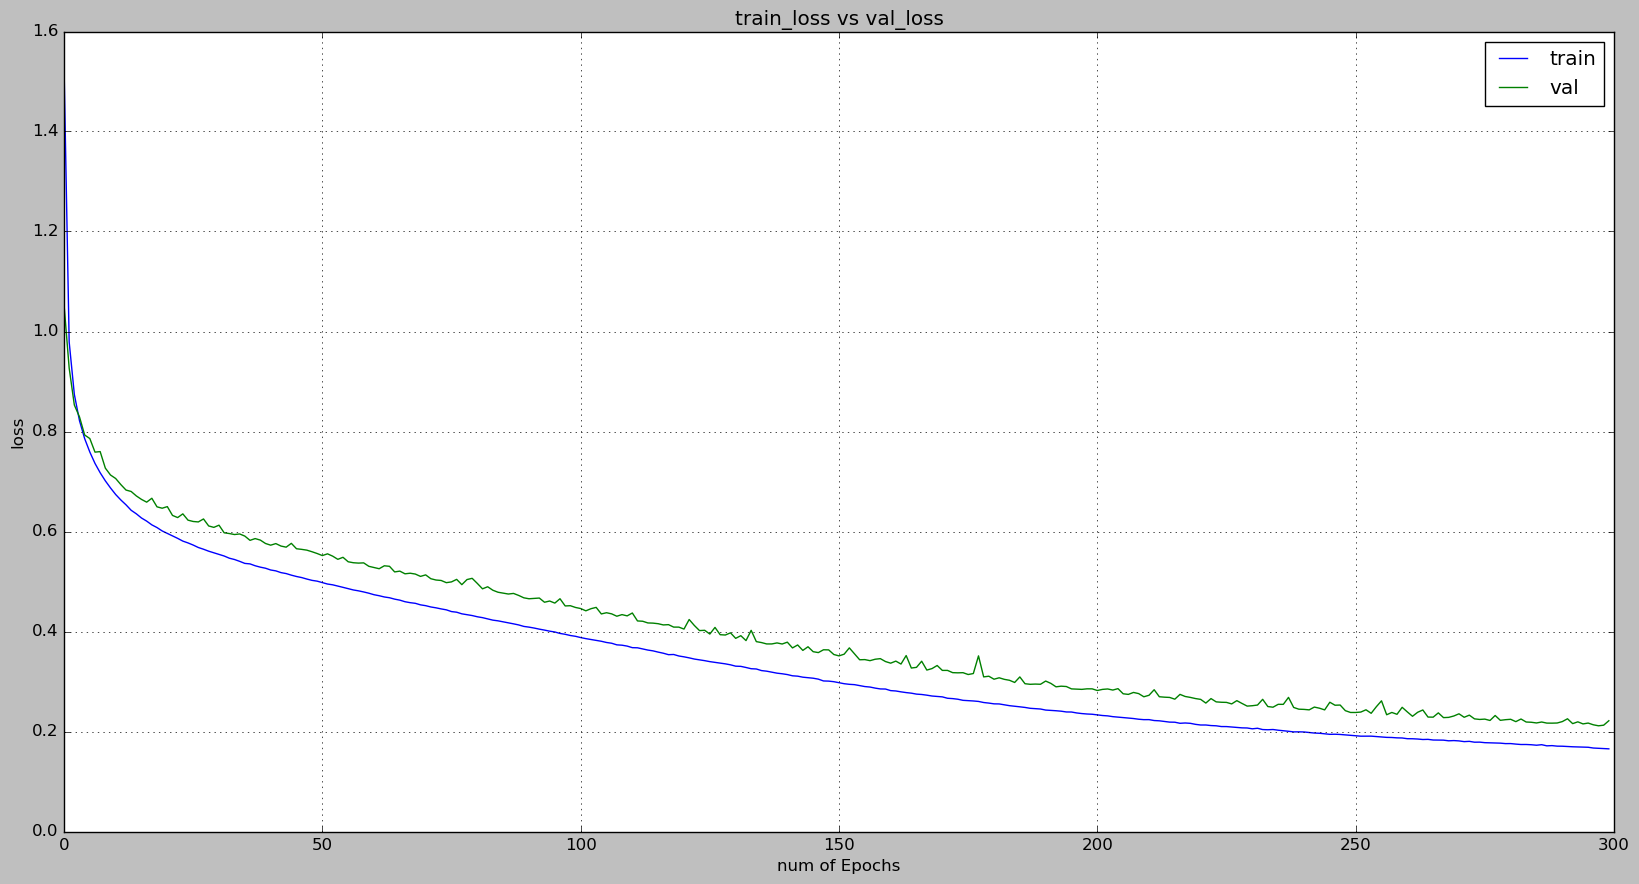

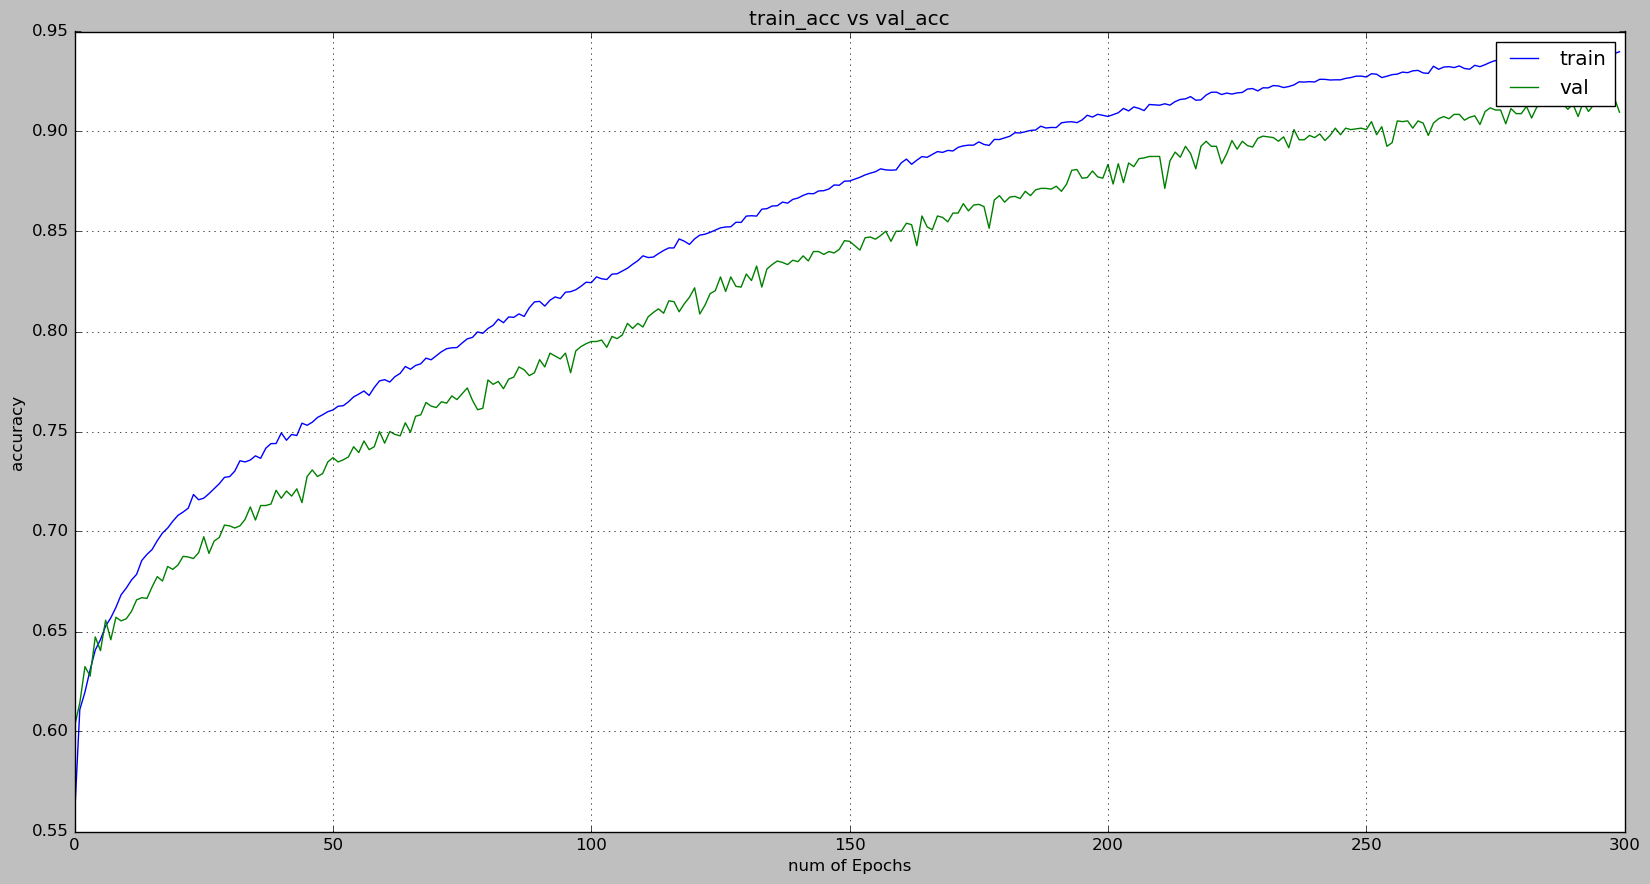

In [35]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=100)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=100)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

In [37]:
#predict on the test data
X_test, Y_test = load_resized_test_data(img_rows, img_cols)
print(X_test.shape, Y_test.shape)
print('-'*30)
print('Predicting on the test data...')
print('-'*30)
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

(2756, 100, 100, 3) (2756, 2)
------------------------------
Predicting on the test data...
------------------------------
2756/2756 [==============================] - 1s 286us/step
Test_Accuracy =  0.9038461538461539


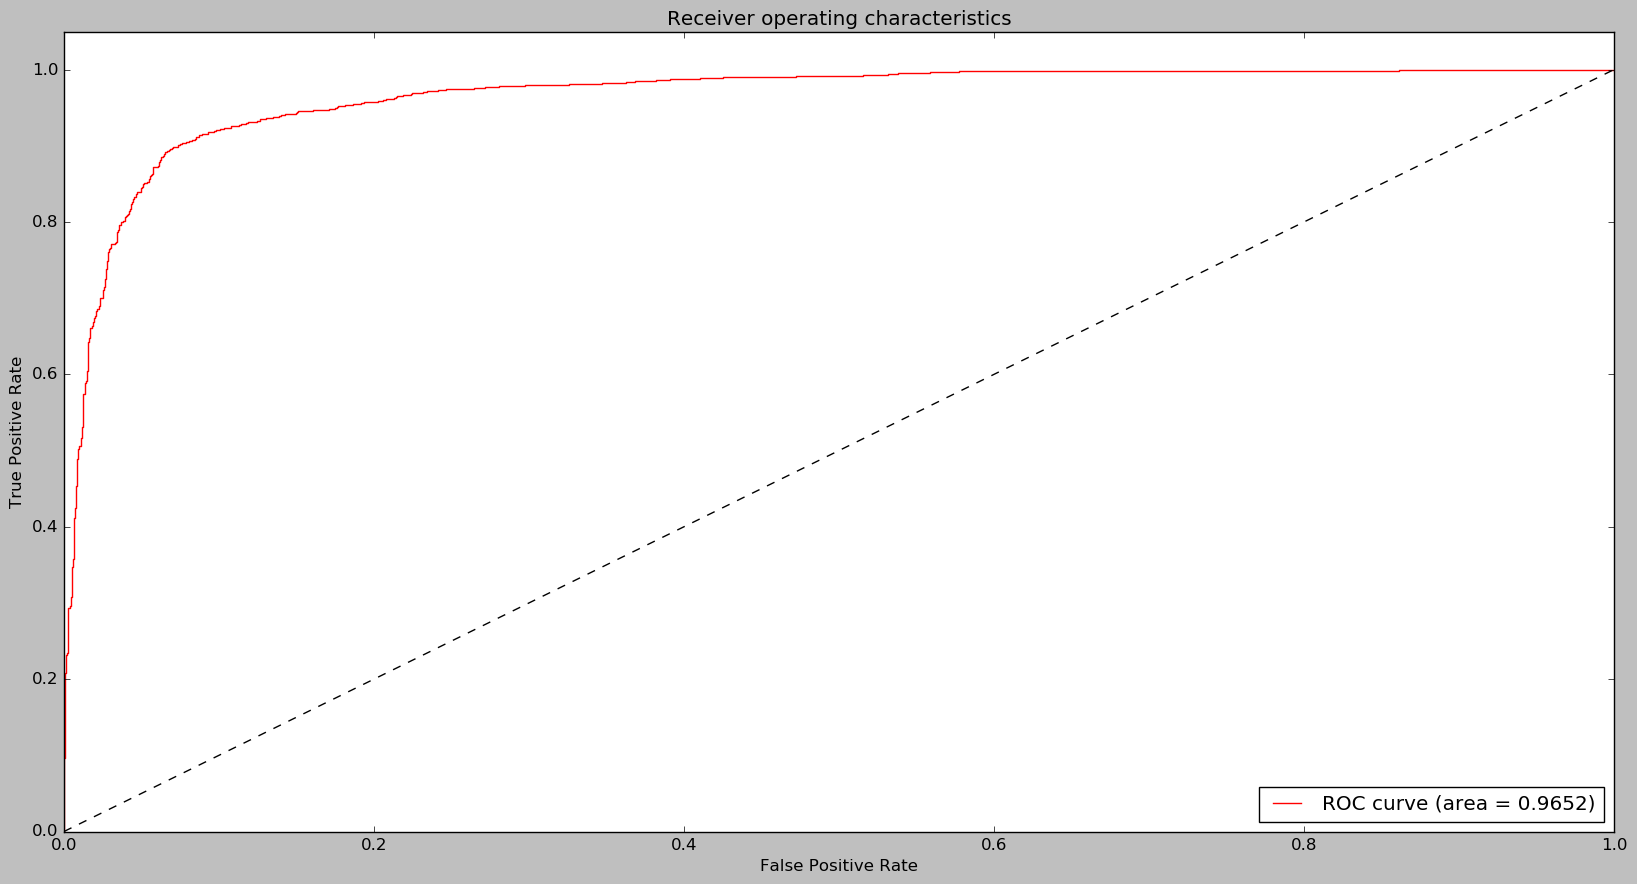

0.25396101495279516
0.9643536063055733
[0 0 1 ... 1 0 0]
[0 0 1 ... 1 0 0]


In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(20,10), dpi=100)
lw = 1
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print(prec_score)

# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print(y_pred)
print(Y_test)

#save the predictions as a CSV file for further analysis
np.savetxt('custom_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('custom_model_Y_test.csv',Y_test,fmt='%i',delimiter = ",")

                   precision    recall  f1-score   support

class 0(abnormal)       0.88      0.94      0.91      1409
  class 1(normal)       0.94      0.86      0.90      1347

        micro avg       0.90      0.90      0.90      2756
        macro avg       0.91      0.90      0.90      2756
     weighted avg       0.91      0.90      0.90      2756

[[1329   80]
 [ 185 1162]]
Confusion matrix, without normalization
[[1329   80]
 [ 185 1162]]


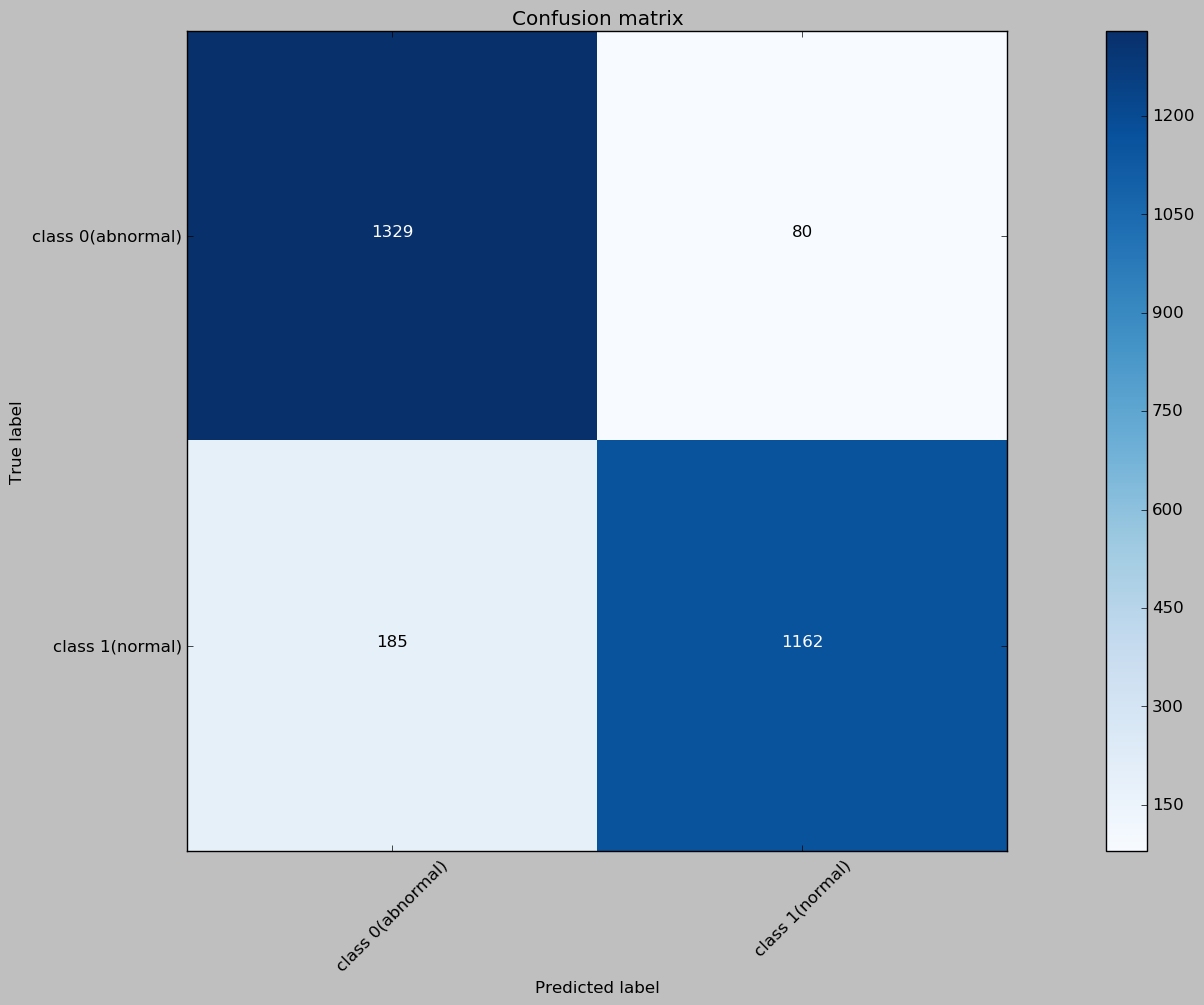

In [39]:
target_names = ['class 0(abnormal)', 'class 1(normal)'] #decide the labels for your own data
print(classification_report(Y_test,y_pred,target_names=target_names))
print(confusion_matrix(Y_test,y_pred))
cnf_matrix = (confusion_matrix(Y_test,y_pred))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()